In [35]:
# 1.目的
# 着番の予想精度を上げるため、通過順位を説明変数に用いたい
# 通過順位は出走前はわからないため、予想する必要がある
# 予想脚質、馬番、直近タイム指数を説明変数に用い、ゴール直近の通貨順位に対して有用なのか調べたい
# また、ついでに予想脚質がどのくらい正確に予想できているのかも知りたい
# （正確なのであれば、例えば予想脚質が"逃げ"ならゴール直前の通貨順位は小さいはず）
# 2.やったこと
# XGBoostを使う。目的変数を通過順位として各説明変数を使って高い精度を出せるか調べる
# ただし、学習データは同レースにおける馬の脚質予想の割合でフィルタリングしてから分析に用いる
# なぜならば、脚質予想の割合が異なるレースが混じっている状態で正しく分析できないからである
# 例えば通過順位が3位であるとしても、以下の2パターンが考えられる
# ・予想脚質が追込である馬が8頭中6頭いて、追込の馬が後方集団にいながら通過順位が3位である
# ・予想脚質が逃げである馬が8頭中3頭いて、逃げの馬が前方集団にいながら通過順位が3位である
# 3.結果に対する所感
# 予想脚質、馬番、直近タイム指数は通過順位に有意であると考えられる
# 特に逃げ・先行の頭数と差し・追込の頭数の差が小さいほど有意である
# ただし逃げ・先行の頭数が差し・追込みの頭数を上回る場合においては一部有意ではない結果が得られる

In [120]:
# インポート
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns

In [146]:
# 説明変数を作る
# 作る説明変数は通過順位（予想）とタイム指数平均（レースに出走する馬の平均値との差）
# CSVファイルを読み込む
df = pd.read_csv('input_編集後.csv', encoding='utf-8')
filtered_df = df[df['position_4'].notna()]
print(f"dfの行数は {len(df)} ")
# 最終コーナーの通過順位を取得
df['position_final_corner'] = df[['position_4', 'position_3', 'position_2', 'position_1']].bfill(axis=1).iloc[:, 0]
# 日付順に並び替え（馬ごとに過去レースの順番を明確に）
df['race_date'] = pd.to_datetime(df['race_date'])  # 日付が文字列なら変換
df = df.sort_values(by=['horse', 'race_date'])
# 過去Nレースの最終コーナー通過順位の平均を計算
df['avg_position_final_corner_last_N_races'] = (
    df.groupby('horse', group_keys=False)['position_final_corner']
    .apply(lambda x: x.shift(1).rolling(window=3, min_periods=3).mean())
)
# 過去Nレースの最終コーナー通過順位の中央値を計算
sum_races = 3
df['median_position_final_corner_last_N_races'] = (
    df.groupby('horse', group_keys=False)['position_final_corner']
    .apply(lambda x: x.shift(1).rolling(window=sum_races, min_periods=sum_races).median())
)
# フィルタ条件を適用
filtered_df = df[
    df['position_4'].notna() &
    (df['race_date'].dt.year >= 2023) &
    (df['race_date'].dt.year <= 2024)
]
print(f"filtered_dfの行数は {len(filtered_df)} ")
# レースID、馬番順に並び替え
filtered_df = filtered_df.sort_values(by=['race_id', 'horse_number'])
# 結果を確認
print(filtered_df[filtered_df['race_date'] == '2023-06-06'][[
    'race_date',
    'race_id',
    'horse_number',
    'avg_position_final_corner_last_N_races',
    'median_position_final_corner_last_N_races',
    'position_final_corner'
]])
# NaNである割合を確認
nan_ratio = filtered_df['median_position_final_corner_last_N_races'].isna().mean()
print(f"NaNの割合: {nan_ratio:.2%}")



# レースごとの馬のタイム指数の平均値を計算し、タイム指数との差を計算する
race_avg_time_index = filtered_df.groupby('race_id')['time_index_average_1'].transform('mean')
# 平均との差を新しいカラムとして追加
filtered_df['time_index_diff_from_avg'] = filtered_df['time_index_average_1'] - race_avg_time_index
# style_nameはカテゴリ変数であり文字列だがそのまま使えないのでエンコーディングして数値に変換する
# 脚質を one-hot エンコーディングして、レースIDごとに集計
style_counts = pd.get_dummies(filtered_df['style_name']).groupby(filtered_df['race_id']).sum()
# 列名をわかりやすく変更
style_counts = style_counts.rename(columns={
    '逃げ': '逃げ頭数',
    '先行': '先行頭数',
    '差し': '差し頭数',
    '追込': '追込頭数'
})
# 元の df にマージ（レースIDに基づいて）
filtered_df = filtered_df.merge(style_counts, left_on='race_id', right_index=True)
# 逃げ + 先行 の合計カラムを追加
filtered_df['前方頭数'] = filtered_df['逃げ頭数'] + filtered_df['先行頭数']
# 差し + 追込 の合計カラムを追加
filtered_df['後方頭数'] = filtered_df['差し頭数'] + filtered_df['追込頭数']
# 明示的にマッピングする辞書を定義
style_mapping = {
    '逃げ': 1,
    '先行': 2,
    '差し': 3,
    '追込': 4
}
front_back_mapping = {
    '逃げ': 1,
    '先行': 1,
    '差し': 2,
    '追込': 2
}
# 新しい列 'style_encoded' を追加（元の 'style_name' 列はそのまま）
filtered_df['style_encoded'] = filtered_df['style_name'].map(style_mapping)
# 新しい列 'style_encoded' を追加（元の 'style_name' 列はそのまま）
filtered_df['front_back_encoded'] = filtered_df['style_name'].map(front_back_mapping)
# 頭数の割合でフィルタリング
number_of_horses = 8
number_of_FR = 3
number_of_RR = number_of_horses - number_of_FR
filtered_df = filtered_df[(filtered_df['前方頭数'] == number_of_FR) & (filtered_df['後方頭数'] == number_of_RR)]
print(f"フィルタリング後のレコード数: {len(filtered_df)}")
# 結果を確認
print(filtered_df[[
    "race_id",
    "time_index_diff_from_avg",
    "style_encoded",
    "avg_position_final_corner_last_N_races",
    "median_position_final_corner_last_N_races",
    "position_4"
]].head(8))

dfの行数は 51816 
filtered_dfの行数は 11952 
       race_date    race_id  horse_number  \
34008 2023-06-06  230606Z06             1   
34009 2023-06-06  230606Z06             2   
34010 2023-06-06  230606Z06             3   
34011 2023-06-06  230606Z06             4   
34012 2023-06-06  230606Z06             5   
34013 2023-06-06  230606Z06             6   
34014 2023-06-06  230606Z06             7   
34015 2023-06-06  230606Z06             8   

       avg_position_final_corner_last_N_races  \
34008                                     NaN   
34009                                4.000000   
34010                                     NaN   
34011                                     NaN   
34012                                     NaN   
34013                                3.666667   
34014                                3.000000   
34015                                4.000000   

       median_position_final_corner_last_N_races  position_final_corner  
34008                                    

In [148]:
# レースIDの先頭2桁を抽出（文字列として扱う）
filtered_df.loc[:, 'race_id_year'] = filtered_df['race_id'].astype(str).str[:2]
# 件数カウント
count_23 = (filtered_df['race_id_year'] == '23').sum()
count_24 = (filtered_df['race_id_year'] == '24').sum()
# 割合を計算
rate_24 = count_24 / (count_23 + count_24)
# 結果表示
print(f"24の割合: {rate_24:.2f}")
# 説明変数
x1 = filtered_df[[
    "style_encoded",
    "horse_number",
#    "avg_position_final_corner_last_N_races",
    "median_position_final_corner_last_N_races",
    "time_index_diff_from_avg"
]]
# 目的変数
y1 = filtered_df["position_1"]
# 学習データと検証データの分割（検証データ割合はrate_24）
x1_train, x1_test, y1_train, y1_test = train_test_split(x1, y1, train_size=rate_24, shuffle=False)
# モデルの学習
model1 = xgb.XGBRegressor(
    objective='reg:squarederror',
    max_depth=1,
    learning_rate=0.09,
    n_estimators=100,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
model1.fit(x1_train, y1_train)
# 予測
y1_pred = model1.predict(x1_test)
# 回帰の場合→XGBRegressorを使う
# 説明変数
x4 = filtered_df[[
    "style_encoded",
    "horse_number",
#    "avg_position_final_corner_last_N_races",
    "median_position_final_corner_last_N_races",
    "time_index_diff_from_avg"
]]
# y4を予想するための説明変数x4にy1_predを追加する
# x4[y1_pred] = y1_pred
# 目的変数
y4 = filtered_df["position_4"]
# 学習データと検証データの分割（検証データ割合はrate_24）
x4_train, x4_test, y4_train, y4_test = train_test_split(x4, y4, train_size=rate_24, shuffle=False)
# モデルの学習
model4 = xgb.XGBRegressor(
    objective='reg:squarederror',
    max_depth=1,
    learning_rate=0.09,
    n_estimators=100,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
model4.fit(x4_train, y4_train)
# 予測
y4_pred = model4.predict(x4_test)
# y*_predの評価
rmse1 = np.sqrt(mean_squared_error(y1_test, y1_pred))
r2_1 = r2_score(y1_test, y1_pred)
print(f"RMSE_1: {rmse1:.4f}")
print(f"R2_1 Score: {r2_1:.4f}")
rmse4 = np.sqrt(mean_squared_error(y4_test, y4_pred))
r2_4 = r2_score(y4_test, y4_pred)
print(f"RMSE_4: {rmse4:.4f}")
print(f"R2_4 Score: {r2_4:.4f}")
# y*_rankの評価
# 予測結果を DataFrame に変換して race_id と紐付け
y_pred_df = pd.DataFrame({
    'race_id': filtered_df.loc[x4_test.index, 'race_id'].values,
    'y1_pred': y1_pred,
    'y4_pred': y4_pred
})
# 各レースごとに予測値の小さい順に順位を振る（昇順）
y_pred_df['y1_rank'] = y_pred_df.groupby('race_id')['y1_pred'].rank(method='first').astype(int)
y_pred_df['y4_rank'] = y_pred_df.groupby('race_id')['y4_pred'].rank(method='first').astype(int)
# 3. 実着順を追加
y_pred_df['y1_actual'] = y1_test.values
y_pred_df['y4_actual'] = y4_test.values
# 実データを出力して確認
y_pred_df.sort_values(by=['race_id', 'y4_actual'], ascending=[True, True]).head(120)
# y4_pred_df.sort_values(by=['race_id', 'y4_actual'], ascending=[True, True]).head(120)

24の割合: 0.48
RMSE_1: 1.7400
R2_1 Score: 0.4228
RMSE_4: 1.8656
R2_4 Score: 0.3319


,race_id,y1_pred,y4_pred,y1_rank,y4_rank,y1_actual,y4_actual
4,231205Z04,2.244105,2.697565,1,1,1,1.0
5,231205Z04,2.852518,2.919460,2,2,2,2.0
2,231205Z04,5.414658,5.834484,6,7,4,3.0
1,231205Z04,4.690857,4.537164,4,3,3,4.0
7,231205Z04,5.757831,5.895352,7,8,7,5.0
...,...,...,...,...,...,...,...
115,240109D11,2.852518,2.919460,3,2,2,4.0
112,240109D11,6.068449,6.208836,7,7,6,5.0
119,240109D11,5.263634,5.807142,6,6,5,5.0
113,240109D11,5.075774,5.399723,5,5,7,7.0


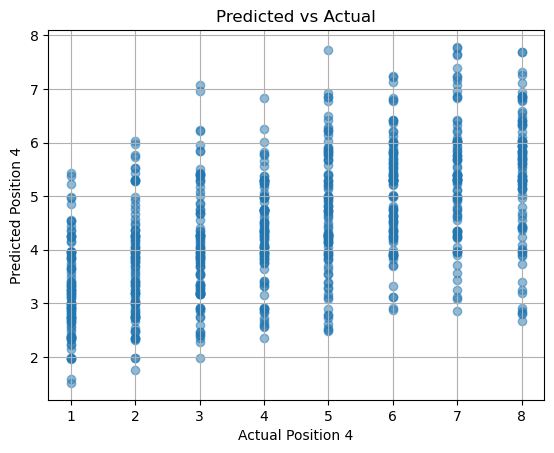

各特徴量の重要度（大きいほど重要）:
                                     Feature  Importance
0                              style_encoded    0.455351
3                   time_index_diff_from_avg    0.385522
2  median_position_final_corner_last_N_races    0.120217
1                               horse_number    0.038910


C:\Users\ryo\AppData\Local\Temp\ipykernel_14168\1025448196.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')


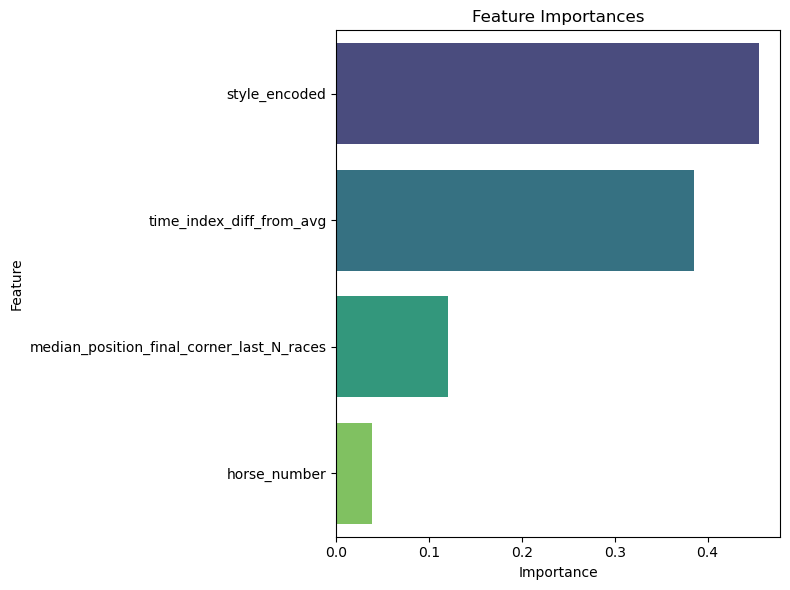

In [126]:
# 予想と正解のプロット
plt.scatter(y4_test, y4_pred, alpha=0.5)
plt.xlabel("Actual Position 4")
plt.ylabel("Predicted Position 4")
plt.title("Predicted vs Actual")
plt.grid(True)
plt.show()
# 特徴量の重要度
importances = model4.feature_importances_
feature_names = x4.columns
# DataFrameにしてソート
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)
print("各特徴量の重要度（大きいほど重要）:")
print(importance_df)
plt.figure(figsize=(8, 6))
sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')
plt.title("Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


In [158]:
# すでにある列を削除（再実行対策）
filtered_df = filtered_df.drop(columns=[
    'style_encoded_of_max_rank_diff',
    'style_encoded_of_max_last_3_furlongs',
    'y1_rank', 'y4_rank'
], errors='ignore')
# 通過順位と着番の差を計算してdfに出力する
# x1_test.index（または x4_test.index）を使って、y_pred_df に元の index を追加
y_pred_df['index'] = x4_test.index
y_pred_df = y_pred_df.set_index('index')
# filtered_df に rank 情報（予測順位）をマージ
filtered_df = filtered_df.join(y_pred_df[['y1_rank', 'y4_rank']], how='left')
# finish_rank と y4_rank の順位差を新しいカラムとして追加
filtered_df['rank_diff'] = filtered_df['y4_rank'] - filtered_df['finish_rank']
# rank_diff が最大となる index（NaN除外）
idx_max_rank_diff = filtered_df.groupby('race_id')['rank_diff'].idxmax().dropna()
# last_3_furlongs が最大となる index（NaN除外）
idx_max_last_3f = filtered_df.groupby('race_id')['last_3_furlongs'].idxmax().dropna()
# style_encoded の辞書を作成
style_of_max_rank_diff_dict = (
    filtered_df.loc[idx_max_rank_diff, ['race_id', 'style_encoded']]
    .dropna()
    .set_index('race_id')['style_encoded']
)
style_of_max_last_3f_dict = (
    filtered_df.loc[idx_max_last_3f, ['race_id', 'style_encoded']]
    .dropna()
    .set_index('race_id')['style_encoded']
)
# map により filtered_df にカラム追加（元の順序を保持）
filtered_df['style_encoded_of_max_rank_diff'] = filtered_df['race_id'].map(style_of_max_rank_diff_dict)
filtered_df['style_encoded_of_max_last_3_furlongs'] = filtered_df['race_id'].map(style_of_max_last_3f_dict)
# レースごとに差分を確認
print(filtered_df[[
    'race_id',
    'horse_number',
    'style_encoded',
    # 'finish_rank',
    # 'y4_rank',
    'rank_diff',
    'last_3_furlongs',
    'style_encoded_of_max_rank_diff',
    'style_encoded_of_max_last_3_furlongs'
]].dropna().head(16))

         race_id  horse_number  style_encoded  rank_diff  last_3_furlongs  \
40424  231205Z04             1            2.0       -4.0             40.5   
40425  231205Z04             2            3.0        0.0             38.5   
40426  231205Z04             3            3.0        5.0             37.6   
40427  231205Z04             4            3.0       -1.0             38.3   
40428  231205Z04             5            2.0        0.0             39.4   
40429  231205Z04             6            2.0       -2.0             40.5   
40430  231205Z04             7            4.0       -1.0             38.6   
40431  231205Z04             8            3.0        3.0             38.5   
40592  231210Z07             1            3.0        1.0             39.0   
40593  231210Z07             2            1.0        1.0             37.9   
40594  231210Z07             3            4.0        2.0             40.2   
40595  231210Z07             4            4.0        1.0             38.2   